# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset.

to build the project from ground up, download the via <a href ="https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip" >here</a> and put the unziped file in **./traffic-signs-data** folder

The pickled data is a dictionary with 4 key/value pairs:
- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle
import csv
training_file = "./traffic-signs-data/train.p"
testing_file = "./traffic-signs-data/test.p"
symbol_file = "./traffic-signs-data/signnames.csv"

sign_names = []
with open(symbol_file,mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        sign_names.append(row['SignName'])  

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_test, y_test = test['features'], test['labels']

In [105]:
### a basic data summary.
import random
import numpy as np
# number of training examples
n_train = len(x_train)

# number of testing examples
n_test = len(x_test)
choosen_idx = random.choice(range(n_train))

# shape of an image
choosen_image = x_train[choosen_idx]
image_shape = list(choosen_image.shape)

# the unique classes are in the dataset, they can be found by applying them to a set
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [32, 32, 3]
Number of classes = 43


This image is: Yield


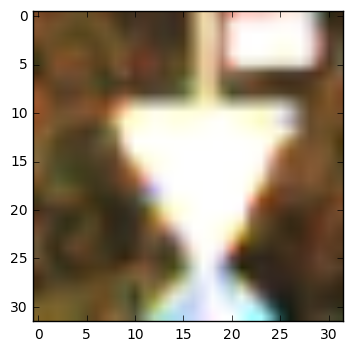

In [106]:
### Data exploration visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# pritn the random selected image and its sign name
plt.imshow(choosen_image)
print('This image is:', sign_names[y_train[choosen_idx]])


## Step 2: Design and Test a Model Architecture


### Question 1
Describe how you preprocessed the data. Why did you choose that technique?

**A:**

Since oringinal data was given as both traing and testing data and their labels, we want to first load our data into the cache, and shuffle the data with corresponding labels within each set(so we can sure the data is not sequentially dependet). or load those data/labels from our previously preporcessed files     

the preprocessing steps including:
1. Loading and saving data unit
2. training/testing set preprocessing(data/labels shuffling) unit
3. load or preprocess(if no saved files found) dataset    



##### Loading and saving data unit
This unit is for saving and loading a preprocessed data and corresponding labels to/from specified paths

In [4]:
import numpy as np
from pathlib import Path
import pickle

def load_saved_data_labels(data_path, labels_path):
    data_path_chk = Path(data_path).is_file()
    labels_path_chk = Path(labels_path).is_file()
    if data_path_chk and labels_path_chk:
        with open(data_path,'rb') as fp:
            saved_data = pickle.load(fp)
        with open(labels_path,'rb') as fp:
            saved_labels = pickle.load(fp)
        return saved_data, saved_labels
    else:
         raise LookupError("can't find {} or {}".format(data_path, labels_path))
        
        
def create_and_save_data_labels(data_path, labels_path,data, labels):
    with open(data_path, 'wb') as fp:
        pickle.dump(data, fp)
    with open(labels_path, 'wb') as fp:
        pickle.dump(labels, fp)


##### training/testing set Preprocessing Unit
Processing input data and labels 

In [5]:
import cv2
def shuffle_data_and_labels(data, labels):
    idx_ary = list(range(len(data)))
    random.shuffle(idx_ary)
    new_data = list(map(lambda idx:data[idx], idx_ary))
    new_labels = list(map(lambda idx:labels[idx], idx_ary))
    return new_data, new_labels

"""
# does't see huge imporvement in speed when reduce to one channel using GPU, therefore keep using 3 channels
preprocess the data by first reduce data channels, and shuffle the data 
"""
def data_set_preporcessing(data, labels):
#     reduced_data = list(map(lambda img:cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), data))

    return shuffle_data_and_labels(data, labels)

##### Load data and labels 

In [6]:
train_data_path = "./shuffled_train_data"
train_labels_path = "./shuffled_train_labels"
test_data_path = "./shuffled_test_data"
test_labels_path = "./shuffled_test_labels"

"""
try to load the shuffled preprocessd(i.e: reduce_channels, shuffle, reshape)
data(i.e: both training and testing) from specified paths. If files not exist,
start the prepocessing processes
"""

# for training
try:
    shuffled_train_data,shuffled_train_labels = load_saved_data_labels(train_data_path, train_labels_path)

except:

    shuffled_train_data,shuffled_train_labels = data_set_preporcessing(x_train, y_train)

    create_and_save_data_labels(train_data_path,
                                train_labels_path,
                                shuffled_train_data,
                                shuffled_train_labels)

# for testing
try:
    shuffled_test_data,shuffled_test_labels = load_saved_data_labels(test_data_path, test_labels_path)

except:
    shuffled_test_data,shuffled_test_labels = data_set_preporcessing(x_test, y_test)
    create_and_save_data_labels(test_data_path,
                                test_labels_path,
                                shuffled_test_data,
                                shuffled_test_labels)

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**A:** 

we know from above:
1. Number of training examples = 39209
2. Number of testing examples = 12630

we want to seperate a group of data and labels from traning set for validation
the size of the validation set should be around 13% of the original traning set.
And the greatest common divider for the training, validation, test that we choose for this
case is 128(this will be the batch_size for CNN network). 

Therfore
* training_size = 34048
* vaildation_size = 5120
* test_size = 12544

we've crate a DataSets class, so with a dataset object we have *
* train, 
* validation, 
* test 
these three sub-objects. All these sub-objects created from the Batch class

The Batch class have the following properties and method:
* num_examples: returning the size of the specified dataset
* next_batch: return a batch size(data and labels) that specified by the FLAGS. For training, if we finish all batches from an episode, we will create some new argumentated data into the training set   

The idea behind generating some argumentated data from our oringinal data by using some mathmatical transformations is to make sure our model is insensitive to these transformations(in our cases we munipulate pictures from following ways: Gaussian filters, random flip left and right, random rotate picture within certain degree) 





##### Create validation set 

In [7]:
train_set = [train_data,train_labels] =  [shuffled_train_data[:34048][::], shuffled_train_labels[:34048][::]]
validation_set = [validation_data,validation_labels] = [shuffled_train_data[-5120:][::], shuffled_train_labels[-5120:][::]]
test_set = [test_data,test_labels] = [shuffled_test_data[:12544][::], shuffled_test_labels[:12544][::]]


print("train size", len(train_data))
print("validation size", len(validation_data))
print("test size", len(test_data))


train size 34048
validation size 5120
test size 12544


#### DataSets class 

In [8]:
"""
Data sets that has three attributes: train, validation, and test 
each attribute has state of 'num_examples' and method 'next_batch' from above Batch class 
"""

def identity(data):
    return data

class DataSets(object):
    def __init__(self, train_set, validation_set, test_set, FLAGS):
        self.train = Batch(train_set, FLAGS, True)
        self.validation = Batch(validation_set, FLAGS)
        self.test = Batch(test_set, FLAGS)
        # return the internal properties
        identity(self)

#### Batch preprocessing and template 

In [9]:
from copy import deepcopy
import numpy as np
import random
from scipy import ndimage

"""
normalize the data by 255/channel then reshaped the data from
[num_examples, img_width*img_width*num_chnl] to [num_examples, img_width, img_width, num_chnl]
which match our placeholder shape for fisrt layer input data
"""
def batch_set_preprocessing(shuffled_data, FLAGS):

    shuffled_data = list(map(lambda img:img/255.0, shuffled_data))    # normalize data with max value 255
    reshaped_shuffled_data = np.reshape(shuffled_data, (len(shuffled_data),
                                                        FLAGS.img_width,
                                                        FLAGS.img_width,
                                                        FLAGS.img_chnl))
    return reshaped_shuffled_data




def random_distort_training_set(data, num):
    idx_size = len(data)-1
    for idx in range(num):
        # bluring a random img
        distor_contrast_idx = random.randint(0,idx_size)
        data[distor_contrast_idx] = ndimage.gaussian_filter(data[distor_contrast_idx],
                                                            sigma=random.choice([3,5,7]))
        #flip a img lf and right
        distor_flip_idx = random.randint(0,idx_size)
        data[distor_flip_idx] = np.fliplr(data[distor_flip_idx])

        #rotate the image
        distor_rotate_idx = random.randint(0,idx_size)
        data[distor_rotate_idx] = ndimage.interpolation.rotate(data[distor_rotate_idx],
                                                            angle=float(random.randrange(0,90,3)),
                                                            reshape = False)
    return data


class Batch(object):
    def __init__(self, data_set, FLAGS, is_training = False ):
        data, labels = data_set
        self.num_examples = len(data)
        self.counter = 0
        self.data = data
        self.labels = labels
        self.FLAGS = FLAGS
        self.is_training = is_training
        self._data = None

    def next_batch(self):
        """
        reshuffle data amd labels if the counter reach to 0
        for training set, recreate a new disdortion set(300) after shuffle the training set
        """
        batch_size = self.FLAGS.batch_size

        if self.counter == 0:
            self.data, self.labels = shuffle_data_and_labels(self.data, self.labels)
            #keep the original training set by using deepcopy
            self._data = self.data if not self.is_training else random_distort_training_set(deepcopy(self.data),300)

        data = self._data[self.counter:self.counter+batch_size]
        labels = self.labels[self.counter:self.counter+batch_size]

        # increase the counter by batch size and reset to 0 if it reach to the size of data
        self.counter = self.counter+batch_size if self.counter+batch_size<self.num_examples else 0

        # reshape the data into the data shape of the placeholder and normalize
        reshaped_data = batch_set_preprocessing(data, self.FLAGS)
        return reshaped_data.tolist(), labels




# """ 
# if one wants to use Keras as preprocessing, uncomment the following and comment the the above
# """


# from keras.preprocessing.image import ImageDataGenerator

# datagen_distort = ImageDataGenerator(
#                     rotation_range=40,
#                     width_shift_range=0.2,
#                     height_shift_range=0.2,
#                     rescale=1./255,
#                     shear_range=0.2,
#                     zoom_range=0.2,
#                     horizontal_flip=True,
#                     fill_mode='nearest')

# datagen_normal = ImageDataGenerator(rescale=1./255)


# class Batch(object):
#     def __init__(self, data_set, FLAGS, is_training = False ):
#         data, labels = data_set
#         self.num_examples = len(data)
#         self.counter = 0
#         self.is_training = is_training
#         self.data, self.labels = reshape_images(data, FLAGS), np.array(labels)     
#         self.batch_generator =  self.start_batch_generator(FLAGS.batch_size)
#         self.is_done = False
        
#     def done(self):
#         self.is_done = True
#         next(self.batch_generator)

#     generator method for fetch data batch
#     def start_batch_generator(self, batch_size):
#         if self.is_training: 
#             datagen_distort.fit(self.data)
#             for X_batch, Y_batch in datagen_distort.flow(self.data, self.labels, batch_size=batch_size):
#                 if self.is_done: break 
#                 yield X_batch, Y_batch
#         else:
#             for X_batch, Y_batch in datagen_normal.flow(self.data, self.labels, batch_size=batch_size):
#                 if self.is_done: break 
#                 yield X_batch, Y_batch
            
#     def next_batch(self):
#         data_batch, labels_batch = next(self.batch_generator)
#         return data_batch.tolist(), labels_batch.tolist()
        
        
# #         """        
# #         reshuffle data amd labels if the counter reach to 0 
# #         for training set, recreate a new disdortion set(300) after shuffle the training set 
# #         """        
# #         if self.counter == 0:
# #             self.data, self.labels = shuffle_data_and_labels(self.data, self.labels)
            

# #         # increase the counter by batch size and reset to 0 if it reach to the size of data 
# #         self.counter = self.counter+batch_size if self.counter+batch_size<self.num_examples else 0
        
# #         # reshape the data into the data shape of the placeholder  
# # #         reshaped_data = batch_set_preprocessing(data)
# #         return reshaped_data.tolist(), labels



    


---
#### Utilitis for placeholder  

In [10]:
import tensorflow as tf 


"""Generate placeholder variables to represent the input tensors.
These placeholders are used as inputs by the rest of the model building
code and will be fed from the downloaded data in the .run() loop, below.
Args:
batch_size: The batch size will be baked into both placeholders.
Returns:
images_placeholder: Images placeholder.
labels_placeholder: Labels placeholder.
"""
def placeholder_inputs(batch_size):
    images_placeholder = tf.placeholder(tf.float32, shape=(batch_size, FLAGS.img_width, FLAGS.img_width, FLAGS.img_chnl))
    
    labels_placeholder = tf.placeholder(tf.int32, shape=(batch_size))

    return images_placeholder, labels_placeholder




"""Fills the feed_dict for training the given step.
Args:

inputs: - keep_prob: dropoff layers keep probability 
        - data_set: The set of inpt data and its labels
        
placeholders: - keep_prob_pl: The keep_prob placeholder 
              - images_pl: The images placeholder
              - labels_pl: The labels placeholder     
Returns:
feed_dict: The feed dictionary mapping from placeholders to values.

A feed_dict takes the form of:
feed_dict = {
  <placeholder>: <tensor of values to be passed for placeholder>,
  ....
}
"""

def fill_feed_dict(inputs, placeholders):

    [keep_prob, data_set] = inputs

    images_feed, labels_feed = data_set.next_batch()

    [keep_prob_pl, images_pl, labels_pl] = placeholders

    feed_dict = {
        keep_prob_pl: keep_prob,
        images_pl: images_feed,
        labels_pl: labels_feed
    }

    return feed_dict

#### Utilities for layers and evaluation

In [189]:
import time
import tensorflow
from functools import reduce




def evaluation(logits, labels):
    accuracy = tf.nn.in_top_k(logits, labels, 1)
    return tf.reduce_sum(tf.cast(accuracy, tf.int32))

"""Runs one evaluation against the full epoch of data.
Args:
sess: The session in which the model has been trained.
eval_correct: The Tensor that returns the number of correct predictions.
images_placeholder: The images placeholder.
labels_placeholder: The labels placeholder.
data_set: The set of images and labels to evaluate
"""
def do_eval(sess,
            eval_correct,
            placeholders,
            data_set,
            FLAGS):
    
    # And run one epoch of eval.
    true_count = 0  # Counts the number of correct predictions.
    steps_per_epoch = data_set.num_examples // FLAGS.batch_size
    num_examples = steps_per_epoch * FLAGS.batch_size
    
    # toggle all keep_prob back to 1 during evaluation 
    feed_dict = fill_feed_dict([1.0,data_set], placeholders)

    for step in range(steps_per_epoch):
        true_count += sess.run(eval_correct, feed_dict=feed_dict)
        
    precision = true_count / num_examples
    print('Num examples: %d  Num correct: %d  Precision @ 1: %0.04f' %
        (num_examples, true_count, precision))


def conv_relu(layer_input, kernel_shape, bias_shape, stride, name, FLAGS):

    # Create variable named "weights".
    weights = tf.get_variable("weights",
                              kernel_shape,
                              initializer=tf.truncated_normal_initializer(stddev=0.1))

    # Create variable named "biases".
    biases = tf.get_variable("biases",
                             bias_shape,
                             initializer=tf.constant_initializer(0.0))

    conv = tf.nn.conv2d(layer_input,
                        weights,
                        strides=[1, stride, stride, 1],
                        padding='SAME')
    return tf.nn.relu(conv + biases, name=name+'_conv')


def max_pool(layers, stride, k, name):
    return tf.nn.max_pool(layers,
                          ksize = [1,k,k,1],
                          strides = [1, stride, stride,1],
                          padding = 'SAME',
                          name = name+'_pool')


def fc_with_relu(layer_input,
                 kernel_shape,
                 bias_shape,
                 name,
                 is_final_layer,
                 keep_prob,
                 FLAGS
                 ):
    
    # Create variable named "weights".
    weights = tf.get_variable(name+"_weights", kernel_shape,
                        initializer=tf.truncated_normal_initializer(stddev=0.05))

    # Create variable named "biases".
    biases = tf.get_variable(name+"_biases", bias_shape,
                        initializer=tf.constant_initializer(0.0))

    if is_final_layer: return tf.add(tf.matmul(layer_input, weights), biases, name=name)

    layer = tf.nn.relu(tf.matmul(layer_input, weights) + biases, name=name)

    return tf.nn.dropout(layer, keep_prob)


def inference(input_data, FLAGS, keep_prob):
    layers_struct= FLAGS.layer_structs
    for idx,(layer_name, layer_info) in enumerate(layers_struct["conv"].items()):
        conv_layer_input = input_data if idx == 0 else conv_layer_input
        [kernal_shape, bias_shape, conv_stride, use_pool, max_pool_stride, max_pool_k] = layer_info
        with tf.variable_scope(layer_name):

            conv2d = conv_relu(conv_layer_input,
                                kernal_shape,
                                bias_shape,
                                conv_stride,
                                layer_name,
                                FLAGS)

            conv_layer_input = max_pool(conv2d,
                                        max_pool_stride,
                                        max_pool_k,
                                        layer_name) if use_pool else conv2d

    re_shaped_conv_layer_input = tf.reshape(conv_layer_input,
                                    [-1,layers_struct["fc"]["fully_connected"][0][0]])

    final_fc_idx = len(layers_struct["fc"].items())-1
    for idx,(layer_name, layer_info) in enumerate(layers_struct["fc"].items()):
        fc_layer_input = re_shaped_conv_layer_input if idx == 0 else fc_layer_input
        [kernal_shape, bias_shape] = layer_info
        is_final_layer = (idx == final_fc_idx)
        with tf.variable_scope(layer_name):

            final_output = fc_with_relu(fc_layer_input,
                                        kernal_shape,
                                        bias_shape,
                                        layer_name,
                                        is_final_layer,
                                        keep_prob,
                                        FLAGS)
        fc_layer_input = final_output
    return final_output


def loss(logits, labels, fc_layer_struct):
    labels = tf.to_int32(labels)
    
    # this line is used for prevent dead ReLu due if a neuron is 0 at forward pass
    logits = tf.add(logits, 1e-10)
    
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
                        logits, labels, name='cross_entropy_per_example')
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    loss = cross_entropy_mean

#     """
#         L2 regulization(skip this since we use dropout )
#     """
    # regularizers = None
    # for layer_name, layer_info in fc_layer_struct.items():
    #     with tf.variable_scope(layer_name, reuse=True):
    #         # Open variables named  "weights" and "biases".
    #         weights = tf.get_variable("weights")
    #         biases = tf.get_variable("biases")
    #         # calculate cumulative L2 loss in fully-connected layers
    #         regularizers = tf.nn.l2_loss(weights)+tf.nn.l2_loss(biases) if regularizers == None else regularizers+tf.nn.l2_loss(weights)+tf.nn.l2_loss(biases)

    # loss = cross_entropy_mean +  5e-4 * regularizers
    return loss


def train(loss, learning_rate):
    tf.summary.scalar('loss',loss)
    opt = tf.train.AdamOptimizer(learning_rate)
    train_op = opt.minimize(loss)
    return train_op





def run_training(continue_training=True, load_model=False):
#     tf.reset_default_graph()
#     print (continue_training, load_model)
    with tf.Graph().as_default():
        images_placeholder, labels_placeholder = placeholder_inputs(FLAGS.batch_size)

        keep_prob = tf.placeholder(tf.float32)

        placeholders = [keep_prob, images_placeholder, labels_placeholder]

        logits = inference(images_placeholder, FLAGS, keep_prob)

        loss_op = loss(logits, labels_placeholder, FLAGS.layer_structs["fc"])

        train_op = train(loss_op, FLAGS.learning_rate)

        eval_accuracy = evaluation(logits, labels_placeholder)

        summary = tf.summary.merge_all()

        saver = tf.train.Saver(tf.global_variables())

        init = tf.global_variables_initializer()

        sess = tf.Session()

        summary_writer = tf.summary.FileWriter(FLAGS.input_data_dir, sess.graph)

        sess.run(init)

        if load_model:
            
            new_saver = tf.train.import_meta_graph(FLAGS.log_dir+'/model.ckpt-59.meta')

            new_saver.restore(sess, tf.train.latest_checkpoint(FLAGS.log_dir))


        if continue_training:
            
            for step in range(FLAGS.max_epoches):

                data_set = data_sets.train

                steps_per_epoch = data_set.num_examples // FLAGS.batch_size
                num_examples = steps_per_epoch * FLAGS.batch_size

                start_time = time.time()

                train_inputs = [FLAGS.keep_prob, data_set]

                for num in range(steps_per_epoch):
                    feed_dict = fill_feed_dict(train_inputs, placeholders)
                    _, loss_val = sess.run(
                                    [train_op, loss_op],
                                    feed_dict=feed_dict
                                    )

                duration = time.time() - start_time

                print('epoch %d: loss = %.2f (%.3f sec)' % (step, loss_val, duration))

                summary_str = sess.run(summary, feed_dict=feed_dict)
                summary_writer.add_summary(summary_str, step)
                summary_writer.flush()

                if step % 2 == 0:
                    print('Validation Data Eval:')
                    do_eval(sess,
                            eval_accuracy,
                            placeholders,
                            data_sets.validation,
                            FLAGS)


                if (step + 1) % FLAGS.save_steps == 0 or (step + 1) == FLAGS.max_epoches:
                    checkpoint_path = os.path.join(FLAGS.log_dir, 'model.ckpt')
                    saver.save(sess, checkpoint_path, global_step=step)

 
        # Finished all epoches, evaluate training and test set
        print('Training Data Eval:')
        do_eval(sess,
                eval_accuracy,
                placeholders,
                data_sets.train,
                FLAGS)

        # Evaluate against the test set.
        print('Test Data Eval:')
        do_eval(sess,
                eval_accuracy,
                placeholders,
                data_sets.test,
                FLAGS)

 ### Question 3

What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)

**A:** 

For this project we used a Convolutional Neural Network
The whole network has two parts:
    1. Training. Training has three sub parts  
        * inference - define the structure of the CNN
        * loss - define the loss and upgrade of the hyperparamters during training  
        *  Training - train each bach of images and labels with te setup above
    2. Evaluation. Evaluate a dataset with the inferenece and hyperparamters that we obtain from training 


The network has two type of layers, and their specification is as follow:

1. 2D convolutional layers
    * layer_1: taking image ($32*32*3$) and patch the image 64 filters with $5*5$ filter_width(kernal_shape) and then use $2*2$ max_pooling layer last ReLu activation 
    * layer_2: taking output from previous layer ($16*16*64$) and patch with 128 filters with $5*5$ filter_width(kernal_shape) and then use $2*2$ max_pooling layer last ReLu activation
    * layer_3: taking output from previous layer ($8*8*128$) and patch with 256 filters with $5*5$ filter_width(kernal_shape) last ReLu activation
    * layer_4: taking output from previous layer($8*8*256$) and patch with 512 filters with $5*5$ filter_width(kernal_shape) and then use $2*2$ max_pooling layer last ReLu activation
2. fully connected layers
    * fully_connected: taking the input from above(layer_4) and flatten the input($4*4*512$) and use that to feed into 768 fully connected neurons 
    * fully_connected_2: taking the input from above feed(768) into 1536 fully connected neurons
    * final_output: taking the input from above and feed into 43(number of different signs) fully connected neurons


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

**A:**
* optimzer: adam
* keep rate for the fully connected layers beside final layer : 0.5 
* learning rate: 1e-4
* batch size: 128
* epoch: 60



#### CNN layers structure and hyperparameters

In [190]:
from collections import OrderedDict
import argparse
import sys
import os
import tensorflow as tf

# function that use for start the training process or load previously trained model 
def main(_):
    tf.gfile.MakeDirs(FLAGS.log_dir)
    program_strart_time = time.time()
    print ("starting time: ",program_strart_time)
    
    # to restart the train process delete all parameters in run_training     
    run_training(False, True)
    
    program_end_time = time.time()
    print ("ending time: ", program_end_time)



# conv [kernal_shape, bias_shape, conv_stride, max_pool_stride, max_pool_k]

conv_layer_width = OrderedDict([
    ('layer_1', [[5,5,3,64],[64],1,True, 2,2]),
    ('layer_2', [[5,5,64,128],[128],1,True,2,2]),
    ('layer_3', [[5,5,128,256],[256],1,False, None,None]),
    ('layer_4', [[5,5,256,512],[512],1,True,2,2]),
    ])

#fc [kernal_shape, bias_shape]

fc_layer_width = OrderedDict(
    [
     ('fully_connected', [[4*4*512, 768], [768]]),
     ('fully_connected_2', [[768, 1536], [1536]]),
     ('final_output',[[1536, n_classes], [n_classes]])]
    )

# two type of layers within the CNN 
CNN_layer_structure = {
    'conv': conv_layer_width,
    'fc': fc_layer_width
    }    


# define value for hyperparameters within the network
parser = argparse.ArgumentParser()
parser.add_argument(
  '--layer_structs',
  type=dict,
  default=CNN_layer_structure,
  help='CNN layers name and their structual info.'
)
parser.add_argument(
  '--img_width',
  type=int,
  default=32,
  help='image width.'
)
parser.add_argument(
  '--img_chnl',
  type=int,
  default=3,
  help='image channels.'
)
parser.add_argument(
  '--learning_rate',
  type=float,
  default=1e-4,
  help='Initial learning rate.'
)
parser.add_argument(
  '--max_epoches',
  type=int,
  default=100,
  help='Number of epoches to run trainer.'
)
parser.add_argument(
  '--batch_size',
  type=int,
  default=128,
  help='Batch size.  Must divide evenly into the dataset sizes.'
)
parser.add_argument(
  '--keep_prob',
  type=float,
  default=0.5,
  help='keep probability for each dropout layer within the fully connected layes'
)
parser.add_argument(
  '--input_data_dir',
  type=str,
  default='./data/input_data',
  help='Directory to put the input data.'
)
parser.add_argument(
  '--log_dir',
  type=str,
  default='./logs/fully_connected_feed_3',
  help='Directory to put the log data.'
)
parser.add_argument(
  '--summary_steps',
  type=int,
  default=10,
  help='Step size for summary.'
)
parser.add_argument(
  '--save_steps',
  type=int,
  default=3,
  help='Step size for saving .'
)

# initialize all hyperparameters 
FLAGS, unparsed = parser.parse_known_args()

# create the dataset from data/labels 
data_sets = DataSets(train_set, validation_set, test_set, FLAGS)

# run the main function below  
tf.app.run()




starting time:  1483478687.053826
here
Training Data Eval:
Num examples: 34048  Num correct: 34048  Precision @ 1: 1.0000
Test Data Eval:
Num examples: 12544  Num correct: 12250  Precision @ 1: 0.9766
ending time:  1483479812.216478


SystemExit: 

/Users/seanhuang/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Question 5
_What approach did you take in coming up with a solution to this problem?_
The following ways were the method I used to build the model
* understand and build a simple CNN based on the LeNet, and train the model on simple MNIST data the provided by Tensorflow(this will give a good starting ground)
* rebuild/modified the model based on the CIFAR-10 model that provided by Tensorflow, so the code can be more modulize and decoupled. Wtih those, one can define all the structure and hyperparameters at the end of the model all in one place
* build helper functions(argumentation, batches, etc) that used to help manipulated images for training
* tuning and optimizing parameters 



---

## Step 3: Test a Model on New Images


In [368]:
# block that used to load the pretrained model, and then used to model to classify an images array 
import tensorflow as tf 

def eval_pictures(pics_ary,k=1, FLAGS=FLAGS):
    tf.reset_default_graph()
    pics_ary_classified = []
    with tf.Graph().as_default():
        
        images_placeholder = tf.placeholder(tf.float32, shape=(1, FLAGS.img_width, FLAGS.img_width, FLAGS.img_chnl))
         
        keep_prob = tf.placeholder(tf.float32)

        logits = inference(images_placeholder, FLAGS, keep_prob)

        init = tf.global_variables_initializer()
        
        sess = tf.Session()
        sess.run(init)
        
        saver = tf.train.Saver()
        
        saver.restore(sess, tf.train.latest_checkpoint(FLAGS.log_dir))
        
        # classify one image at a time 
        for image in pics_ary:
            # normalize the same way as we did in training 
            image = image/255.0
            # reshape image into the same shape as placeholder 
            image = np.reshape(image,(1,32,32,3))
            
            logit_val = sess.run(logits, feed_dict={
                                                images_placeholder: image,
                                                keep_prob: 1.0})
            val, indices = tf.nn.top_k(logit_val, k)
            val = val.eval(session=sess)
            indices = indices.eval(session=sess)
            if k==1:
                pics_ary_classified.append(sign_names[indices[0]])
            else:
                pics_ary_classified.append((val, indices))
        sess.close()
    
    return pics_ary_classified



In [366]:
#block that used for ploting image with the classification result 
def plot_graph_with_classify(all_img, classify_res):
    import matplotlib.pyplot as plt
    %matplotlib inline
    fig = plt.figure()
    for idx in range(len(all_img)):

        fig.add_subplot(len(all_img), 1, idx+1)
        plt.axis('off')
        plt.title(classify_res[idx], fontsize=8)
        plt.imshow(all_img[idx])
        plt.subplots_adjust(left=0.1, right=0.9, top=1.2, bottom=0.1)


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**A:**
we've randomly choosen 5 images from the training dataset, and the classification have predict the right result 


/Users/seanhuang/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


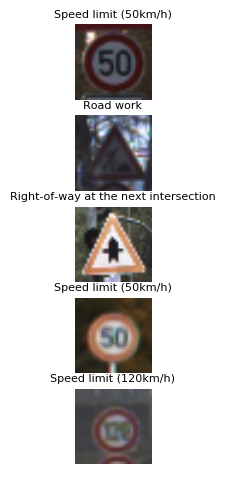

In [364]:
import random 
# pick 5 random indice from the training set  
Q_6_five_random_idx = random.sample(range(len(shuffled_train_data)), 5)

Q_6_five_random_imgs = [shuffled_train_data[idx] for idx in Q_6_five_random_idx]

Q_6_classified_res = eval_pictures(Q_6_five_random_imgs)

plot_graph_with_classify(Q_6_five_random_imgs, Q_6_classified_res)


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**A:**
we randomly choose 5 images from the test dataset, and the classification have also predict the right result 

/Users/seanhuang/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


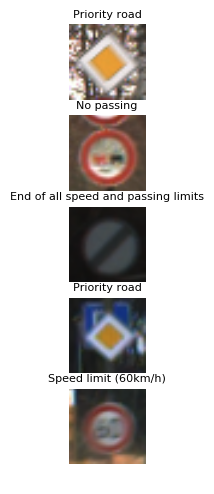

In [365]:
import random 
# pick 5 random indice from the training set  
Q_7_five_random_idx = random.sample(range(len(shuffled_test_data)), 5)

Q_7_five_random_imgs = [shuffled_test_data[idx] for idx in Q_7_five_random_idx]

Q_7_classified_res = eval_pictures(Q_7_five_random_imgs)

plot_graph_with_classify(Q_7_five_random_imgs, Q_7_classified_res)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**A:**

we can input k = 5 into the **eval_pictures** function with the same random pictures from Q7. Below we plot each graph together with its classification confident level. The result shows for each graph and its classification the cofident level for the top pick catagory is higher than the other catagories.  

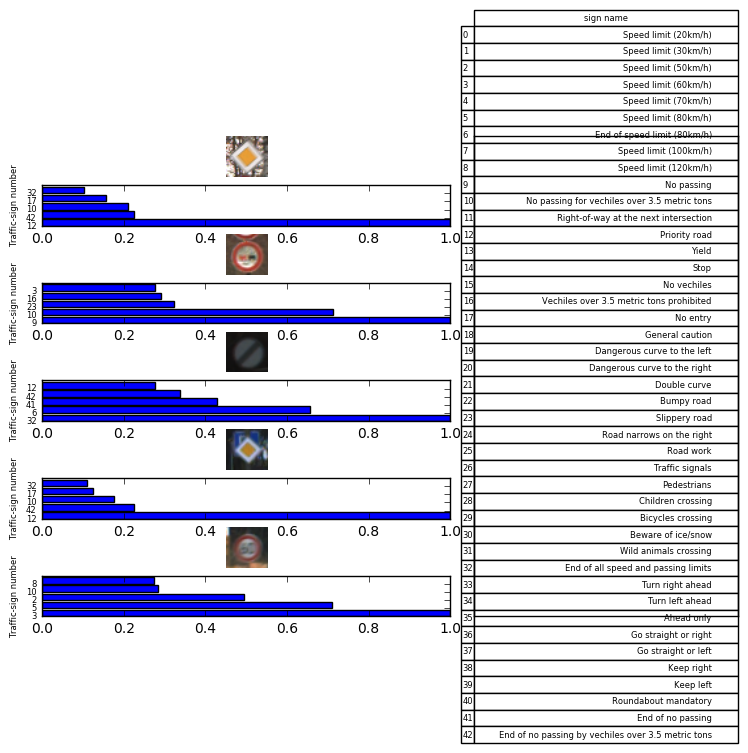

In [514]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

fig = plt.figure()


Q_8_classified_res = eval_pictures(Q_7_five_random_imgs, 5)

gs = gridspec.GridSpec(2*len(Q_7_five_random_imgs), 6)

for idx in range(len(Q_7_five_random_imgs)):

    fig.add_subplot(gs[2*idx,1:4])
    plt.axis('off')
    plt.imshow(Q_7_five_random_imgs[idx])

    fig.add_subplot(gs[2*idx+1,1:4])
    
    # normalize the confident level between 0 and 1 
    y = Q_8_classified_res[idx][0]/np.max(Q_8_classified_res[idx][0])
    y = y[0]

    x = Q_8_classified_res[idx][1].tolist()[0]
    x_len = np.arange(len(x))

    plt.barh(x_len, y)

    plt.yticks(x_len, x, fontsize = 6)
    plt.ylabel('Traffic-sign number', fontsize=6)
    plt.subplots_adjust(left=0.1, right=1.5, top=1.2, bottom=0)

ax = fig.add_subplot(gs[:,4:])
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)

col_name = ["sign name"]
row_name = [str(idx) for idx in range(len(sign_names))]
data = [[name] for name in sign_names]

the_table = ax.table(cellText=data, colLabels=col_name, rowLabels = row_name, loc='center')

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**A:** We obainted some other traffic sign pictures(jpg format) from the internet. As we can see from the result, the model can classify signs with similar shape(e.g: "Do not enter") but the model fail on classify the shape that it never see before(e.g: "merge") in its training 

/Users/seanhuang/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


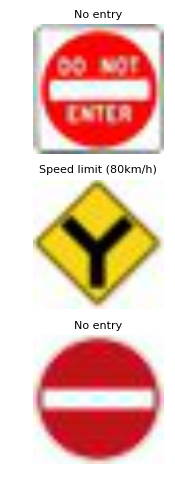

In [515]:
from PIL import Image
import glob

all_img = []
for filename in glob.glob("*.jpg"):
    img=Image.open(filename)
    img.load()
    img.thumbnail((32, 32), Image.ANTIALIAS)
    data = np.asarray( img )
    all_img.append(data)

Q_9_classified_res = eval_pictures(all_img)
plot_graph_with_classify(all_img, Q_9_classified_res)
